In [1]:
%matplotlib inline 

# Regression
***

## Table of Contents
***
* [Aim](#aim)
* [Code Setup](#code-setup)
* [Data Import](#data-import)

## Aim <a class="anchor" id="aim"></a>
***

The aim of this notebook is to perform Regression on the Instacart Data

## Code Setup <a class="anchor" id="code-setup"></a>
***

### Constants

In [2]:
instacart_dir = "instacart_2017_05_01/"
my_orders_file = "my_orders.csv"
products_file = "products.csv"
aisles_file = "aisles.csv"
departments_file = "departments.csv"
orders_products_prior_file = "my_order_products__prior.csv"
orders_products_train_file = "my_order_products__train.csv"

### Import Libraries

In [3]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper")
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [4]:
def read_csv_file(file_name):
    return pd.read_csv(instacart_dir + file_name)

### Import the Data

In [5]:
orders = read_csv_file(my_orders_file)
products = read_csv_file(products_file)
aisles = read_csv_file(aisles_file)
orders_products_prior = read_csv_file(orders_products_prior_file)
orders_products_train = read_csv_file(orders_products_train_file)
orders_products = pd.concat([orders_products_prior, orders_products_train])

In [6]:
def join_products(train, test):
    train_orders_prod = train.merge(orders_products, on="order_id")
    train_orders_prod = train_orders_prod.merge(products, on="product_id")

    test_orders_prod = test.merge(orders_products, on="order_id")
    test_orders_prod = test_orders_prod.merge(products, on="product_id")
    
    return (train_orders_prod, test_orders_prod)

In [7]:
def add_days_to_next_order(order_df):
    orders = order_df.copy()
    orders["days_to_next_order"] = np.nan
    for index, cur_order in orders.iterrows():
        next_order_number = cur_order.order_number + 1
        user_id = cur_order.user_id
        next_order_df = orders.query("user_id == " + str(user_id) + " and  order_number == " + str(next_order_number))
        if(next_order_df.shape[0] == 1):
            next_order = next_order_df.iloc[0]
            days_to_next_order = next_order.days_since_prior_order
            if(np.isfinite(days_to_next_order)):
                orders.loc[index, 'days_to_next_order'] = days_to_next_order
    return orders

In [8]:
def key_columns(next_one):
    list = ["order_id", "days_to_next_order", next_one]
    return list

In [9]:
def split_data_to_features_and_value(df_train, df_test):
    # Target
    y_train = df_train['days_to_next_order'].copy()
    X_train = df_train.copy() 
    # Feature
    X_train.drop(['days_to_next_order'], axis=1, inplace=True)

    # Testing
    y_test = df_test['days_to_next_order'].copy()
    X_test = df_test.copy() 
    # Feature
    X_test.drop(['days_to_next_order'], axis=1, inplace=True)
    return (X_train, y_train, X_test, y_test)

In [10]:
def add_each_aisle_to_df(df):
    df_aisles = df.copy().merge(aisles, on="aisle_id")
    for index, row in aisles.iterrows():
        aisle_name = row.aisle
        df_aisles[aisle_name] = 0
    return df_aisles

In [11]:
def add_each_department_to_df(df):
    df_dep = df.copy().merge(departments, on="department_id")
    for index, row in departments.iterrows():
        department_name = row.department
        df_dep[department_name] = 0
    return df_dep

In [12]:
def add_each_product_to_df(df, popular_products):
    df_products = df.copy().merge(products, on="product_id")
    for index, row in popular_products.iterrows():
        product_name = row.product_name
        df_products[product_name] = 0
    return df_products

In [13]:
def group_by_order_in_df(df_ordered, item_name, cols_to_drop):
    # Create new df with only the column names
    df = df_ordered.copy()
    df.drop(df.index, inplace=True)
    order_ids = df_ordered.order_id.unique().tolist()
    for order_id in order_ids:
        temp_df = df_ordered.query("order_id == " + str(order_id))
        # Need a copy as not to modify something we are iterarting over
        first_row = temp_df.copy().head(1)
        for i, temp_row in temp_df.iterrows():
            temp_name = temp_row[item_name]
            # If the feature is present, set it to 1
            if temp_name in df.columns:
                first_row[temp_name] = 1
        # Add the aggregated entry
        df = pd.concat([df, first_row])
    df = df.drop(cols_to_drop, axis=1)
    return df    

In [14]:
def find_best_feature(X, y, X_test, y_test):
    n_features = X.shape[1]
    # Not zero as some negative scores can happen
    max_score = -100000
    max_feature = None
    for i in range(n_features):
        feature = X.columns[i]
        X_subset = X[[feature]]
        X_test_subset = X_test[[feature]]
        temp_model = linear_model.LinearRegression()
        temp_model.fit(X_subset, y)
        # R squared metric
        temp_model_score = temp_model.score(X_test_subset, y_test)
        if temp_model_score > max_score:
            max_score = temp_model_score
            max_feature = feature
    if max_feature is None :
        print("Issue, max feature not found, size", n_features)
        print(X.columns.values)
    return (max_score, max_feature)

In [15]:
# This is a very brute force way, computing all model possibilities and the solution with the highest score
def order_best_features_and_score(X_train, y_train, X_test, y_test, absolute_max_score):
    n_features = X_train.shape[1]
    model_scores = [0]
    best_features = []
    best_score = -10000
    X_selection = X_train.copy()
    X_test_selection = X_test.copy()
    X_subsets = pd.DataFrame(index=X_train.index)
    X_test_subsets = pd.DataFrame(index=X_test.index)

    for i in range(n_features):
        max_score, next_best_feature = find_best_feature(X_selection, y_train, X_test_selection, y_test)

        X_subset = X_selection[[next_best_feature]]
        X_test_subset = X_test_selection[[next_best_feature]]
    
        X_subsets[next_best_feature] = X_subset
        X_test_subsets[next_best_feature] = X_test_subset
        
        tem_model = linear_model.LinearRegression()
        tem_model.fit(X_subsets, y_train)
        tem_model_score = tem_model.score(X_test_subsets, y_test)
        model_scores.append(tem_model_score)
        
        # Want the model to be better by some amount
        score_increase_threshold = 0.00001
        if(tem_model_score == absolute_max_score) :
            best_score = tem_model_score
            best_features = X_subsets.columns.values
            break
        if (tem_model_score > (best_score + score_increase_threshold)) and (tem_model_score < absolute_max_score) :
            best_score = tem_model_score
            best_features = X_subsets.columns.values

        X_selection.drop([next_best_feature], axis=1, inplace=True)
        X_test_selection.drop([next_best_feature], axis=1, inplace=True)
    return (best_features, best_score, model_scores)

#### Test and training split for all users

In [16]:
test_percentage = 0.2
orders = add_days_to_next_order(orders)
# Can use this to estimate what would be ordered
orders_with_no_next_order = orders[orders['days_to_next_order'].isnull()]
# Can split this into train and test
orders_with_next_order = orders[~orders['days_to_next_order'].isnull()]
train_orders, test_orders = train_test_split(orders_with_next_order, test_size=test_percentage)
print("Training size is :", train_orders.shape[0])
print("Testing size is :", test_orders.shape[0])

Training size is : 228
Testing size is : 58


#### Test and training split for specific user

In [17]:
count_orders = (orders
                .groupby("user_id")
                .size()
                .reset_index(name="count")
                .sort_values(by=['count'], ascending=False)
               )
# Get the most frequent user as this will have the most data associated with it
most_frequeny_user_id =  count_orders.iloc[0].user_id
single_user_orders = orders.query("user_id == " + str(most_frequeny_user_id))
single_user_orders = add_days_to_next_order(single_user_orders)
user_orders_with_next_order = single_user_orders[~single_user_orders['days_to_next_order'].isnull()]
user_train_orders, user_test_orders = train_test_split(user_orders_with_next_order, test_size=test_percentage)
print("User id for single investigation :", most_frequeny_user_id)
print("Training size for single user is :", user_train_orders.shape[0])
print("Testing size for single user is is :", user_test_orders.shape[0])

User id for single investigation : 47562
Training size for single user is : 70
Testing size for single user is is : 18


### Merge Product and Aisle to the data

In [18]:
train_orders_prod, test_orders_prod = join_products(train_orders, test_orders)
train_orders_prod.head()

,Unnamed: 0_x,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_to_next_order,Unnamed: 0_y,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1395898,1227141,83908,prior,5,5,16,6.0,24.0,11624022,43295,1,0,Unsweetened Vanilla Almond Milk,91,16
1,1395903,457091,83908,prior,10,2,18,30.0,13.0,4330183,43295,1,1,Unsweetened Vanilla Almond Milk,91,16
2,1395902,2449975,83908,prior,9,0,17,10.0,30.0,23228984,43295,1,1,Unsweetened Vanilla Almond Milk,91,16
3,2065990,2013970,124199,prior,3,1,11,6.0,5.0,19095148,17553,1,1,Lowfat Blueberry Yogurt,120,16
4,2066024,489825,124199,prior,37,6,16,5.0,14.0,4641539,17553,1,1,Lowfat Blueberry Yogurt,120,16


## Product Investigation
***

In [19]:
key_cols = key_columns("product_id")
wanted_info_train = train_orders_prod[key_cols]
wanted_info_test = test_orders_prod[key_cols]

wanted_info_train.head()

,order_id,days_to_next_order,product_id
0,1227141,24.0,43295
1,457091,13.0,43295
2,2449975,30.0,43295
3,2013970,5.0,17553
4,489825,14.0,17553


### Add Product Columns - Keeping only products which have been bought more than a number of times

In [20]:
# Only doing what products are currenty present in training set and appeared 3 or more times to reduce number of products
min_time_prod_appear = 3
popular_products_ids = (wanted_info_train
                        .groupby("product_id")
                        .size()
                        .reset_index(name="count")
                        .query("count >= " + str(min_time_prod_appear))
                        .product_id
                        .tolist()
                       )
popular_products = products[products['product_id'].isin(popular_products_ids)]
df_with_product_info_train = add_each_product_to_df(wanted_info_train, popular_products)
df_with_product_info_test = add_each_product_to_df(wanted_info_test, popular_products)

### Remove No Longer needed columns

In [21]:
cols_to_drop = ["product_id", "product_name", "order_id", "department_id", "aisle_id"]
item = "product_name"
df_prod_group_train = group_by_order_in_df(df_with_product_info_train, item, cols_to_drop)
df_prod_group_test = group_by_order_in_df(df_with_product_info_test, item, cols_to_drop)

df_prod_group_train.head()

,days_to_next_order,Organic Diced Tomatoes,Jack's Special Salsa Medium Hot,"Noodle Soup, Shin Cup, Gourmet Spicy",Kidz All Natural Baked Chicken Nuggets,Cherry Pomegranate Greek Yogurt,Whole Wheat Cookies Dark Chocolate,Vitamin C Super Orange Dietary Supplement,Yellow Bell Pepper,Wild Wonders Medley Tomato,...,Raisin Cinnamon Swirl Bread,Cream Cheese Stuffed Jalapenos Poppers,Asparagus,S'mores Chocolate Ice Cream,Large Lemon,Organic Avocado,Sweet Onion,Organic Half & Half,White Grape Juice Cocktail,Cucumber Kirby
0,24.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,13.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Create the Training and Test Data with the outputs

In [22]:
X_train, y_train, X_test, y_test = split_data_to_features_and_value(df_prod_group_train, df_prod_group_test)
# Where X are the features and Y is the days to next order (value trying to predict)
X_train.head()

,Organic Diced Tomatoes,Jack's Special Salsa Medium Hot,"Noodle Soup, Shin Cup, Gourmet Spicy",Kidz All Natural Baked Chicken Nuggets,Cherry Pomegranate Greek Yogurt,Whole Wheat Cookies Dark Chocolate,Vitamin C Super Orange Dietary Supplement,Yellow Bell Pepper,Wild Wonders Medley Tomato,Dark Chocolate with Whole Hazelnuts,...,Raisin Cinnamon Swirl Bread,Cream Cheese Stuffed Jalapenos Poppers,Asparagus,S'mores Chocolate Ice Cream,Large Lemon,Organic Avocado,Sweet Onion,Organic Half & Half,White Grape Juice Cocktail,Cucumber Kirby
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Create model using the training data

In [23]:
prod_model = linear_model.LinearRegression()
prod_model.fit(X_train, y_train)
prod_model.intercept_

15.058388157894736

### Score the model based on training

In [24]:
prod_model.score(X_train, y_train)

0.8305176930023348

This appears to be a reasonable number but using the training data to test as a first pass will not show much until we test the training data

### Score the model based on testing data

In [25]:
prod_model.score(X_test, y_test)

-2.1235218293086456e+26

As can be seen this is a very large negative number, meaning the model is very bad and fits the training data too much

### Best Feature of the Model by Train

In [26]:
find_best_feature(X_train, y_train, X_train, y_train)

(0.12098062321299985, '2% Reduced Fat Organic Milk')

Milk is the most popular product so this makes sense

### Best Feature of the Model by Test

In [27]:
find_best_feature(X_train, y_train, X_test, y_test)

(0.25004016955587693, '2% Reduced Fat Organic Milk')

Again Milk is the most popular product so this makes sense, however as the model generated will be different run to run, this may not be milk.

### Find best Model, Score by training

In [28]:
best_features_train, best_score_train, model_scores_train = order_best_features_and_score(X_train, y_train, X_train, y_train, 1.0)
print("Best Score :", best_score_train, "with", len(best_features_train), "features")

best_prod_model_train = linear_model.LinearRegression()
best_prod_model_train.fit(X_train[best_features_train], y_train)

test_score_with_best = best_prod_model_train.score(X_test[best_features_train], y_test)
print("Score with best model using testing data :", test_score_with_best)

Best Score : 0.8365780135979499 with 210 features
Score with best model using testing data : -6.074232761249478e+24


As can be seen the model is terrible (way too much variance) so we need to adjust the score to improve this

### Training R Squared Plot for Varying feature Numbers

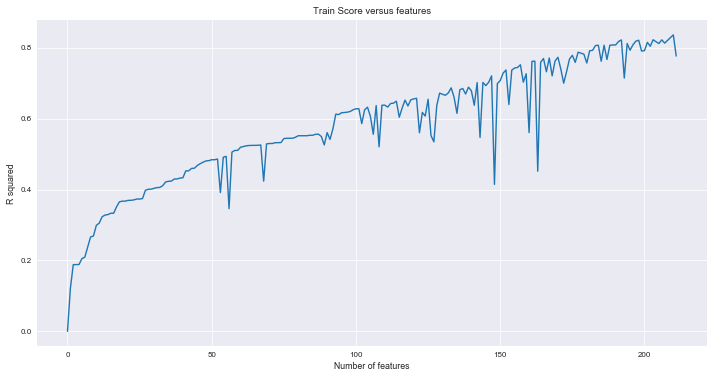

In [29]:
plt.title("Train Score versus features")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores_train)
plt.show()

It can be seen as the Number of Feature increase, the better training model performs, this makes sense as we are overfitting the data so the more data we can give it when testing against the training data, the closer it will get to 1

### Find best Model, Score by testing

In [31]:
best_features_test, best_score_test, model_scores_test = order_best_features_and_score(X_train, y_train, X_test, y_test, 1)
print("Best Score :", best_score_test, "with", len(best_features_test), "features")

best_prod_model_test = linear_model.LinearRegression()
best_prod_model_test.fit(X_train[best_features_test], y_train)

train_score_with_best = best_prod_model_test.score(X_train[best_features_test], y_train)
print("Score with best model using training data to test :", train_score_with_best)

Best Score : 0.38813230814885574 with 18 features
Score with best model using training data to test : 0.1761713377190769


This is very inverse logic. Find the best scoring model made via the training data with certain features/products with the test data being used to score. From this model, score the training data also and see how it performs. 

As can be seen it performs best for the testing data (0.388) and less than half that score for the training data (0.176). Overall it produced more accurate results than that of using the training data only to score then testing the test data off the best model, but the issue now is the test data was used to pick the best model so may now be fitting the test data to the model and the training data scored poorly (still above 0) against the model it was used to create.

### Testing R Squared Plot for Varying feature Numbers

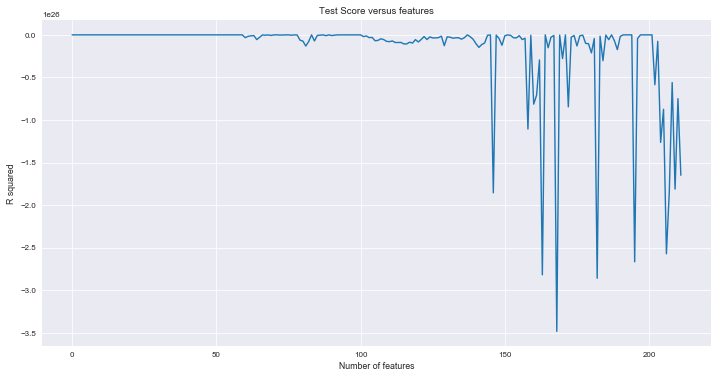

In [32]:
plt.title("Test Score versus features")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores_test)
plt.show()

As can be seen from the graph,the score is in the factor of 10^26 which is huge so as a result we cannot see when the score is above 0, lets take a smaller sample of them. As the score drops down dramatically at 150 but the graph may change depending on models generated so we will pick 40 as the maximum number of score to view.

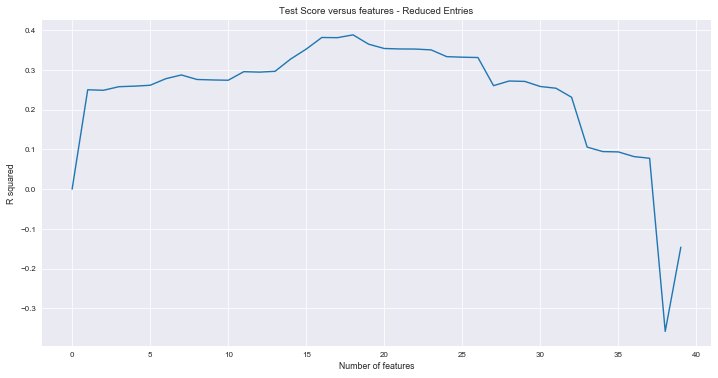

In [37]:
plt.title("Test Score versus features - Reduced Entries")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores_test[:40])
plt.show()

The models appear to perform the best when the have between 15 and 20 features, this depends on the features and also as the models will change with numerous run this graph may change but the point below should still hold.

An issue we have here is that we are using the testing data to find the best model for it, which means we are overfitting the solution to the test data, ideally we should create a model and ensure it has a good score with its own training data then use the testing data to score that single model

### PCA Investigation

In [41]:
# Fit on training set only.
scaler.fit(X_train)


X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

# Make an instance of the Model 
variance = 0.8 # 0.8 means keep 80% of the variance
pca = PCA(variance)
pca.fit(X_train_scale)

X_train_pca = pca.transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)

model = linear_model.LinearRegression()
model.fit(X_train_pca, y_train)
pca_train_score = model.score(X_train_pca, y_train)
pca_test_score = model.score(X_test_pca, y_test)
# Some References
#https://stats.stackexchange.com/questions/82050/principal-component-analysis-and-regression-in-python
#https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

print("Score with training data :", pca_train_score, ". Score with testing data :", pca_test_score)

Score with training data : 0.44581863183061865 . Score with testing data : 0.2025354760876913


Though the score are low here, 0.45 for training and 0.2 for testing, they are still the best we have seen thus far

## Aisle Rollup
***

### Extract Desired Columns

In [ ]:
key_cols = key_columns("aisle_id")
wanted_info_train = train_orders_prod[key_cols]
wanted_info_test = test_orders_prod[key_cols]

wanted_info_train.head()

### Add the Aisle Columns

In [ ]:
df_with_aisle_info_train = add_each_aisle_to_df(wanted_info_train)
df_with_aisle_info_test = add_each_aisle_to_df(wanted_info_test)

df_with_aisle_info_train.head()

### Populate the Aisle Columns

In [ ]:
# Aggregates the data so we have days to next order with the aisles required checked
cols_to_drop = ["aisle", "aisle_id", "order_id"]
item = "aisle"
df_aisle_group_train = group_by_order_in_df(df_with_aisle_info_train, item, cols_to_drop)
df_aisle_group_test = group_by_order_in_df(df_with_aisle_info_test, item, cols_to_drop)

df_aisle_group_train.head()

### Preparing the data for modelling

In [ ]:
X_train, y_train, X_test, y_test = split_data_to_features_and_value(df_aisle_group_train, df_aisle_group_test)
# Where X are the features and Y is the days to next order (value trying to predict)
X_train.head()

### Generate the Model

In [ ]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
model.intercept_

### Find the best feature/aisle

In [ ]:
find_best_feature(X_train, y_train, X_test, y_test)

### Find best features in Order and calculate scores

In [ ]:
best_features, best_score, model_scores = order_best_features_and_score(X_train, y_train, X_test, y_test, 1)
print("Best Score :", best_score)
print(best_features)

In [ ]:
plt.title("Score versus features")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores)
plt.show()

In [ ]:
nbfs, nbs, model_scores = order_best_features_and_score(X_train[best_features], y_train, X_test[best_features], y_test, 1)
print("Best Score :", nbs)
print(nbfs)

In [ ]:
plt.title("Score versus features")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores)
plt.show()

In [ ]:
nnbfs, nnbs, model_scores = order_best_features_and_score(X_train[best_features], y_train, X_train[best_features], y_train, 1)
print("New Best Score :", nnbs)
print(nnbfs)

In [ ]:
plt.title("Score versus features")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores)
plt.show()

### Specific User Investigation

In [ ]:
# For the User
train_orders_prod, test_orders_prod = join_products(user_train_orders, user_test_orders)
wanted_info_train = train_orders_prod[key_cols]
wanted_info_test = test_orders_prod[key_cols]
df_with_aisle_info_train = add_each_aisle_to_df(wanted_info_train)
df_with_aisle_info_test = add_each_aisle_to_df(wanted_info_test)
cols_to_drop = ["aisle", "aisle_id", "order_id"]
item = "aisle"
df_aisle_group_train = group_by_order_in_df(df_with_aisle_info_train, item, cols_to_drop)
df_aisle_group_test = group_by_order_in_df(df_with_aisle_info_test, item, cols_to_drop)
X_train, y_train, X_test, y_test = split_data_to_features_and_value(df_aisle_group_train, df_aisle_group_test)
best_features, best_score, model_scores = order_best_features_and_score(X_train, y_train, X_test, y_test, 1)
print("Best Score :", best_score)
print(best_features)

In [ ]:
plt.title("Score versus features")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores)
plt.show()

In [ ]:
best_features, best_score, model_scores = order_best_features_and_score(X_train[best_features], y_train, X_test[best_features], y_test, 1)
print("Best Score :", best_score)
print(best_features)

In [ ]:
plt.title("Score versus features")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores)
plt.show()

In [ ]:
# NOW WE WANT TO USE PCA/REGULARISATION AND REMOVE SOME UNNEEDED INFO/AISLES

In [ ]:
# DONT FORGET TO MEAN CENTRE